### <font color='DarkCyan'>Что у нас есть:</font>
данные АА-теста с <b>'2022-09-26'</b> по <b>'2022-10-02'</b>. 

### <font color='DarkCyan'>Что нужно сделать:</font>
* Симуляцию 10000 АА-тестов.
* На каждой итерации сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. 
* Провести сравнение подвыборок t-testом.
* Построить гистограмму распределения получившихся 10000 p-values.
* Посчитать, какой процент p values оказался меньше либо равен 0.05
* Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [4]:
import pandas as pd
import pandahouse as ph
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

### <font color='DarkCyan'>Извлечение необходимых данных из базы данных</font>

Данные были извлечены из базы данных с помощью Clickhouse, ниже можно увидеть запрос

In [66]:
'''query = """SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-09-26' and '2022-10-02'
        and exp_group in (2,3)
    GROUP BY exp_group, user_id""" '''

'query = """SELECT exp_group, \n        user_id,\n        sum(action = \'like\') as likes,\n        sum(action = \'view\') as views,\n        likes/views as ctr\n    FROM {db}.feed_actions \n    WHERE toDate(time) between \'2022-09-26\' and \'2022-10-02\'\n        and exp_group in (2,3)\n    GROUP BY exp_group, user_id""" '

In [69]:
df = pd.read_csv('C:/Users/folde/Desktop/aa-test.csv')
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


### <font color='DarkCyan'>Проверка корректности работы системы сплитования с помощью визуальных данных</font>

In [71]:
df['exp_group'].value_counts().to_frame()

,exp_group
3,8569
2,8480


Text(0.5, 1.0, 'Показатель CTR внутри групп')

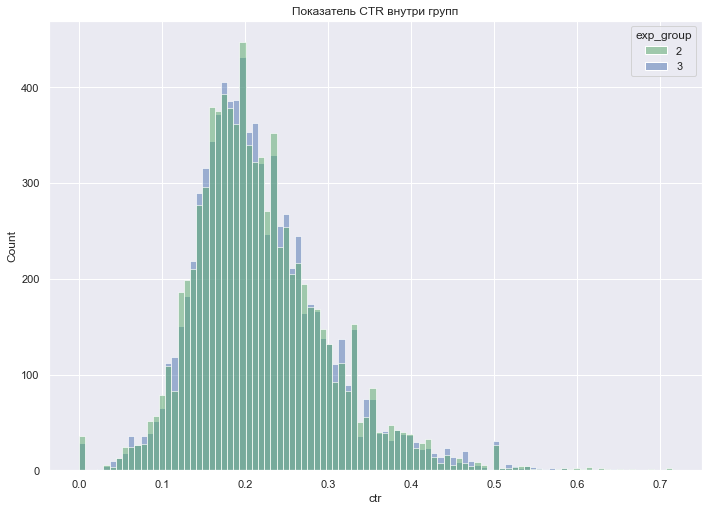

In [72]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['g', 'b'],
              alpha=0.5,
              kde=False)
plt.title('Показатель CTR внутри групп')

### <font color='DarkCyan'>Стандартный t-test</font>

Гипотезы:  
<b>Н0:</b> CTR1=CTR2  
<b>Н1:</b> CTR1 != CTR2

In [73]:
st.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

##### p-value>0,05 => Нельзя опровергнуть гипотезу H0

### <font color='DarkCyan'>Симуляция 10000 АА-тестов</font>

* Проводим симуляцию 10000 АА-тестов.
* На каждой итерации формируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. 
* Сравнение подвыборок t-testом.

In [74]:
p_value_10000 = []

for _ in range(10000):
    group_2 = df[df['exp_group'] == 2].sample(500, replace=False)
    group_3 = df[df['exp_group'] == 3].sample(500, replace=False)
    p_value_10000.append(st.ttest_ind(group_2.ctr, group_3.ctr, equal_var= False)[1])

* Строим гистограмму распределения получившихся 10000 p-values.
* Считаем, какой процент p values оказался меньше либо равен 0.05

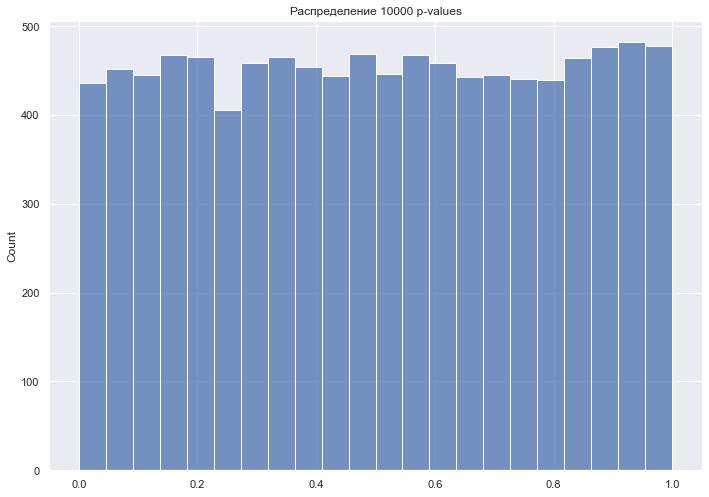

In [75]:
sns.histplot(p_value_10000) 
plt.title('Распределение 10000 p-values')
plt.xlabel = ('p-values')

In [76]:
print(f'{round(len([i for i in p_value_10000 if i <= 0.05])/len(p_value_10000)*100, 2)} знчений p-values оказалось меньше либо равно 0,05')

4.84 знчений p-values оказалось меньше либо равно 0,05


### <font color='DarkCyan'>Вывод</font>

В АА-тесте ложноположительных срабатываний должно быть не более <b>5-ти %</b>. В нашем случае это значение составляет <b>4,86%</b>, соответственно система сплитования работает корректно и группы пригодны для проведения АБ-теста. 